### Sommaire
 
 - <a href="#C1"> 1. Simulation avec K-means, k = 4, SET 1 (RFM) </a>
    - <a href="#C11"> 1.1 Importation </a>
    - <a href="#C12"> 1.2 Simulation </a>
    - <a href="#C13"> 1.3 Résultats </a>

 - <a href="#C2"> 2.  Bonus : Simulation avec méthode mixte, k = 4, SET 2 (RFM + profil éco) </a>
    - <a href="#C21"> 2.1 Simulation </a>
    - <a href="#C22"> 2.2 Résultats </a>


In [5]:
!pip install yellowbrick
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import clean #mon module de fontions qui me permettent de nettoyer un dataframe
import plot_
import sklearn
import time
### ------------ Clustering ----------------
from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
### ------------ Pipeline ------------------
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, RobustScaler,  StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn import set_config
set_config(display="diagram")

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# <a name="C1"> 1. Simulation avec K-means, k = 4, SET 1 (RFM) </a>

## <a name="C11"> 1.1 Importation </a>

In [30]:
  #Set 2, RFM ++ , reste d'échéances + pouvoir d'achat
  df= pd.read_csv('/content/df_agg.csv',
                  usecols = ['fréquence', 'récence_j', 'montant_moy'])

In [31]:
df.head()

,fréquence,récence_j,montant_moy
0,16,133,56.377500
1,9,29,218.175556
2,7,186,139.012857
3,6,609,18.453333
4,6,130,451.745000


### Les hyper paramètres retenus : 

* Nombre de cluster = 4
* Initialisation random
* paramètre lloyd (paramètre par défaut)
* Nombre d'initialisation = auto


In [32]:
df.columns

Index(['fréquence', 'récence_j', 'montant_moy'], dtype='object')

In [33]:
T_0 = df[['fréquence', 'récence_j', 'montant_moy']]
T_k = df[['fréquence', 'récence_j', 'montant_moy']]

In [34]:
len(T_0)

95417

In [35]:
from sklearn.metrics import homogeneity_score, make_scorer, silhouette_score as sc
numeric_transformer =  StandardScaler()
num_features = df.dtypes[df.dtypes != 'object'].index.tolist()
preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, num_features)], remainder='passthrough')

#Data ------------------
X_0 = T_0.values
#Scaling à T_0---------------
scaler_T0 = StandardScaler()
X_0_scaled = scaler_T0.fit_transform(X_0)

In [36]:
state = 38
K_means_pipe_0 = Pipeline([
      ('preprocessor', preprocessor),
      ('K_means_0', sklearn.cluster.KMeans(n_clusters=4,
                                             random_state = state,
                                             init = 'random',
                                             algorithm = 'lloyd',
                                             n_init = 1))])
K_means_pipe_0.fit(T_0)
#Je récupère les centroïd des clusters 
centroids = K_means_pipe_0.named_steps.K_means_0.cluster_centers_

In [37]:
centroids

array([[ 5.11416294, -0.16940031,  0.0347407 ],
       [-0.1610477 ,  0.06171911, -0.05306379],
       [-0.1610477 ,  1.35921072,  0.03635921],
       [-0.1610477 , -1.04064229,  0.02867128]])

## <a name="C12"> 1.2 Simulation </a>

In [38]:
#Test de prédiction sur le fichier clients au temps T=k antérieur à T_0
# Q : Est-ce que le modèle KM0 aurait été valable k mois plus tôt? 
temps_array = np.arange(0,12,0.5) #Itération sur 4 mois après T_0 à raison de pas de 0.25, soit une semaine 
mois_j = 30
ARI_df = pd.DataFrame([])
for k in temps_array: 
  #Fichier clients au temps Tk
  threshold = (df['récence_j'].min() + k*mois_j)
  T_k = T_k[T_k['récence_j'] >= threshold] #Bon en arrière de k*mois
  print(len(T_k))
  X_k = T_k.values
  ARI_df['T_0-'+str(k)+'mois'] = np.nan
#------------------------------------Prédiction avec le pipeline initial------------------------------
  cluster_KM0 = K_means_pipe_0.predict(T_k) 
  print('T_0 -',k,'mois')
  
#------------------------------------Prédiction avec le pipeline k------------------------------------  
  state = 38
  startcenter = centroids
  K_means_pipe_k = Pipeline([
      ('preprocessor', preprocessor),
      ('K_means_k', sklearn.cluster.KMeans(n_clusters=4,
                                             random_state = state,
                                             init = startcenter,
                                             algorithm = 'lloyd',
                                             n_init = 1))])
#Scaling à T_k---------------
  
  K_means_pipe_k.fit(T_k)
  cluster_KMk = K_means_pipe_k.predict(T_k) 
#------------------------------------Comparaison des clusters du dataframe T_k------------------------------------  
  ARI = metrics.adjusted_rand_score(cluster_KM0, cluster_KMk)
  ARI_df.loc[0,'T_0-'+str(k)+'mois'] = ARI
  #print('ARI=',ARI)
  if ARI <0.8 :
    print(ARI, 'Maintenance !')

#----------------------------------Silhouette plot -------------------------------
  #if k in np.arange(2.5,4.5):
   # scaler_Tk = StandardScaler()
   # X_k_scaled = scaler_Tk.fit_transform(X_k) #Également le résultat du pre-processing de K_means_pipe_k
    #X_k_scaled_KM0 = scaler_T0.fit_transform(X_k) #Scaling par rapport à T_0
   # plot_.plot_silhouette(X_k_scaled_KM0,cluster_KM0,4,'/content/Fichier_N3/plot_k_t0.png')
   # plot_.plot_silhouette(X_k_scaled,cluster_KMk,4,'/content/Fichier_N3/plot_k_tk.png')

95417
T_0 - 0.0 mois
93717
T_0 - 0.5 mois
93717
T_0 - 1.0 mois
91947
T_0 - 1.5 mois
91947
T_0 - 2.0 mois
90262
T_0 - 2.5 mois
90262
T_0 - 3.0 mois
88226
T_0 - 3.5 mois
85408
T_0 - 4.0 mois
82384
T_0 - 4.5 mois
79212
T_0 - 5.0 mois
76586
T_0 - 5.5 mois
0.7776258434371478 Maintenance !
73719
T_0 - 6.0 mois
71328
T_0 - 6.5 mois
68394
T_0 - 7.0 mois
66001
T_0 - 7.5 mois
62515
T_0 - 8.0 mois
60118
T_0 - 8.5 mois
0.6162218465153474 Maintenance !
56627
T_0 - 9.0 mois
0.6326153683174335 Maintenance !
53984
T_0 - 9.5 mois
0.7601617880951895 Maintenance !
50681
T_0 - 10.0 mois
0.7233576901066623 Maintenance !
47955
T_0 - 10.5 mois
0.7737234538318396 Maintenance !
44480
T_0 - 11.0 mois
0.6818025877066015 Maintenance !
42559
T_0 - 11.5 mois
0.7054333431932259 Maintenance !


In [39]:
ARI_df  = ARI_df.T
#ARI_df
ARI_df = ARI_df.rename(columns= {0 : 'ARI'})
ARI_df['mois'] = temps_array

## <a name="C13 "> 1.3 Résultats </a>

Text(0.5, 1.0, 'Courbe de maintenance du modèle')

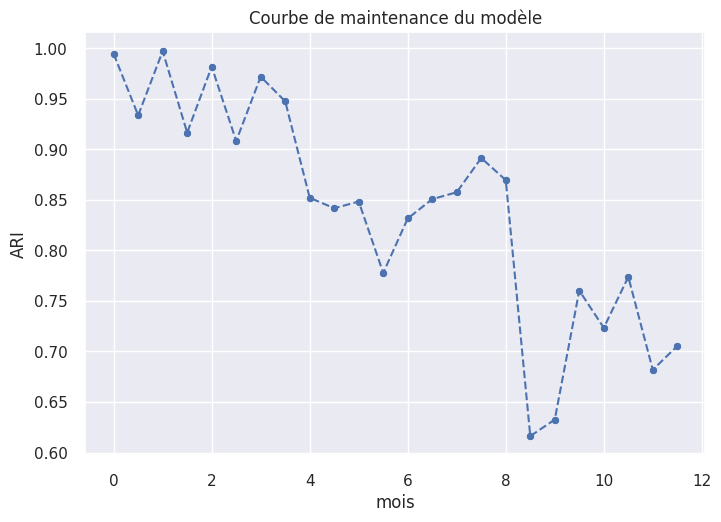

In [40]:
fig,ax = plt.subplots()
sns.set()
sns.scatterplot(data = ARI_df, x = 'mois', y = 'ARI')
sns.lineplot(data = ARI_df, x = 'mois', y = 'ARI', ls ='--')
ax.set_title('Courbe de maintenance du modèle')

Au bout de 5 mois et demi, le modèle initial ne coincide plus avec le modèle du dataset T_k.

# <a name="C2"> 2.  Bonus : Simulation avec méthode mixte, k = 4, SET 2 (RFM + profil éco) </a>

In [ ]:
df= pd.read_csv('/content/df_agg.csv',
                  usecols = ['fréquence', 'récence_j','categorie', 'montant_moy', 
                             'critique_note'
                              ])

In [ ]:
categorie = df.groupby('categorie')['montant_moy'].mean()
categorie = round(categorie,2)
mapping = categorie.to_dict()
df['categorie'] = df['categorie'].replace(mapping)

In [ ]:
from sklearn.metrics import homogeneity_score, make_scorer, silhouette_score as sc
numeric_transformer =  StandardScaler()
num_features = df.dtypes[df.dtypes != 'object'].index.tolist()
preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, num_features)], remainder='passthrough')

In [ ]:
T_0 = df[num_features]
T_k = df[num_features]

In [ ]:
len(T_0)

95417

In [ ]:
#Data ------------------
X_0 = T_0.values
#Scaling à T_0---------------
scaler_T0 = StandardScaler()
X_0_scaled = scaler_T0.fit_transform(X_0)

In [ ]:
df_centroid = pd.read_csv('/content/centroid_mixte_set2.csv',
                          usecols = num_features)


In [ ]:
df_centroid
start = df_centroid.values

In [ ]:
start

array([[-0.16739857, -0.66331606,  0.41591284,  0.1834534 ,  0.9223164 ],
       [ 0.09037875,  0.21245411,  7.42069684, -0.33721146,  0.18144181],
       [ 5.91362139, -0.17605707,  0.22612142, -0.21721703,  0.34086726],
       [-0.16739857,  0.49329886,  0.31469413, -1.51522052, -0.22577801],
       [-0.16739857,  1.53963415,  0.31683135,  0.34797303, -1.3770142 ]])

In [ ]:
state = 38
K_means_pipe_0 = Pipeline([
      ('preprocessor', preprocessor),
      ('K_means_0', sklearn.cluster.KMeans(n_clusters=5,
                                             random_state = state,
                                             init = start,
                                             algorithm = 'lloyd',
                                             n_init = 1))])
K_means_pipe_0.fit(T_0)
centroids = K_means_pipe_0.named_steps.K_means_0.cluster_centers_

## <a name="C21"> 2.1 Simulation </a>

In [ ]:
#Test de prédiction sur le fichier clients au temps T=k antérieur à T_0
# Q : Est-ce que le modèle KM0 aurait été valable k mois plus tôt? 
temps_array = np.arange(0,24,1.) #Itération sur 4 mois après T_0 à raison de pas de 0.25, soit une semaine 
mois_j = 30
ARI_df = pd.DataFrame([])
for k in temps_array: 
  #Fichier clients au temps Tk
  threshold = (df['récence_j'].min() + k*mois_j)
  T_k = T_k[T_k['récence_j'] >= threshold] #Bon en arrière de k*mois
  print(len(T_k))
  X_k = T_k.values
  ARI_df['T_0-'+str(k)+'mois'] = np.nan
#------------------------------------Prédiction avec le pipeline initial------------------------------
  cluster_KM0 = K_means_pipe_0.predict(T_k) 
  print('T_0 -',k,'mois')
  
#------------------------------------Prédiction avec le pipeline k------------------------------------  
  state = 38
  #startcenter = centroids
  K_means_pipe_k = Pipeline([
      ('preprocessor', preprocessor),
      ('K_means_k', sklearn.cluster.KMeans(n_clusters=5,
                                             random_state = state,
                                             init = start, #startcenter,
                                             algorithm = 'lloyd',
                                             n_init = 1))])
#Scaling à T_k---------------
  
  K_means_pipe_k.fit(T_k)
  cluster_KMk = K_means_pipe_k.predict(T_k) 
#------------------------------------Comparaison des clusters du dataframe T_k------------------------------------  
  ARI = metrics.adjusted_rand_score(cluster_KM0, cluster_KMk)
  ARI_df.loc[0,'T_0-'+str(k)+'mois'] = ARI
  #print('ARI=',ARI)
  if ARI <0.8 :
    print(ARI, 'Maintenance !')

#----------------------------------Silhouette plot -------------------------------
#scaler_Tk = StandardScaler()
#X_k_scaled = scaler_Tk.fit_transform(X_k) #Également le résultat du pre-processing de K_means_pipe_k
#X_k_scaled_KM0 = scaler_T0.fit_transform(X_k) #Scaling par rapport à T_0
#plot_.plot_silhouette(X_k_scaled_KM0,cluster_KM0,4,'/content/Fichier_N3/TEST.png')
#plot_.plot_silhouette(X_k_scaled,cluster_KMk,4,'/content/Fichier_N3/TEST.png')

16626
T_0 - 0.0 mois
16626
T_0 - 1.0 mois
16626
T_0 - 2.0 mois
16626
T_0 - 3.0 mois
16626
T_0 - 4.0 mois
16626
T_0 - 5.0 mois
16626
T_0 - 6.0 mois
16626
T_0 - 7.0 mois
16626
T_0 - 8.0 mois
16626
T_0 - 9.0 mois
16626
T_0 - 10.0 mois
16626
T_0 - 11.0 mois
16626
T_0 - 12.0 mois
16626
T_0 - 13.0 mois
16626
T_0 - 14.0 mois
16626
T_0 - 15.0 mois
16626
T_0 - 16.0 mois
16626
T_0 - 17.0 mois
15344
T_0 - 18.0 mois
11916
T_0 - 19.0 mois
0.7240714667056182 Maintenance !
8818
T_0 - 20.0 mois
0.520917368183038 Maintenance !
6110
T_0 - 21.0 mois
0.40117900541297274 Maintenance !
3725
T_0 - 22.0 mois
0.4346945523602113 Maintenance !
1681
T_0 - 23.0 mois
0.44229010740102076 Maintenance !


In [ ]:
ARI_df  = ARI_df.T
#ARI_df
ARI_df = ARI_df.rename(columns= {0 : 'ARI'})
ARI_df['mois'] = temps_array

## <a name="C22"> 2.2 Résultats </a>

Text(0.5, 1.0, 'Courbe de maintenance du modèle')

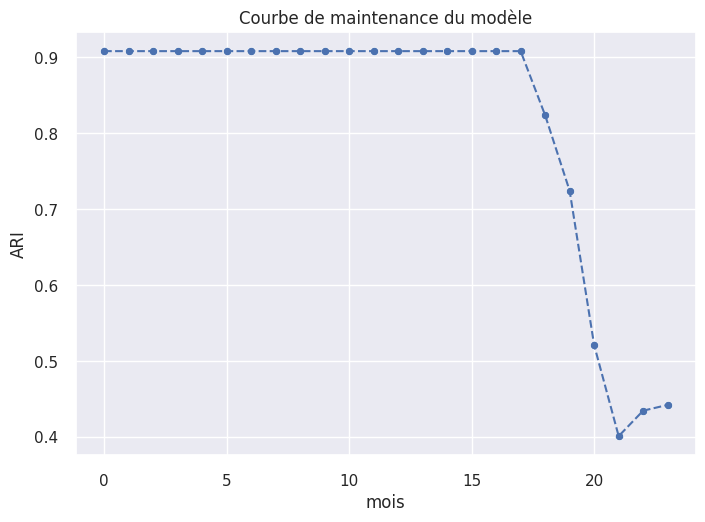

In [ ]:
fig,ax = plt.subplots()
sns.set()
sns.scatterplot(data = ARI_df, x = 'mois', y = 'ARI')
sns.lineplot(data = ARI_df, x = 'mois', y = 'ARI', ls ='--')
ax.set_title('Courbe de maintenance du modèle')

Au bout de 13 mois, le modèle initial ne coincide plus avec le modèle du dataset T_k.